In [1]:
import numpy as np
import muram as muram
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Slice files written every 10 sec (50 time steps)
# Reduced vertical extent subdomains (for RT modeling) every 30 sec (150 time steps)
# Full 3D dumos every 10 minutes (3000 time steps)

# Grid spacing 16km
# Domain size 512x1536x1536
# tau=1 about grid layer 386 (see below)

# Equation of state uses "old" abundaces -> Anders 89, electron density is provided (see below)

In [3]:
path='./'
B_unit=np.sqrt(4*np.pi)
iter=15000

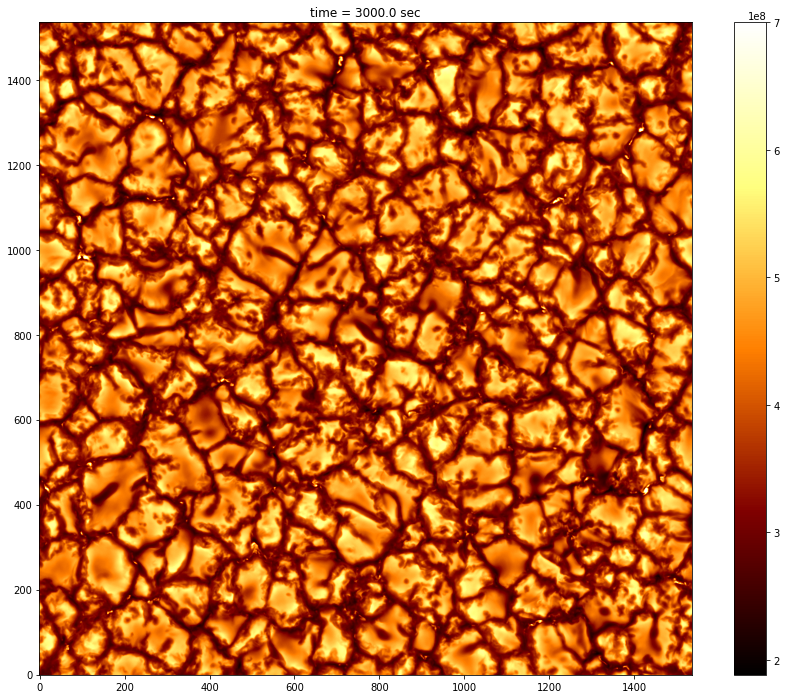

In [4]:
# Intensity for vertical ray at 500 nm
Int=muram.MuramIntensity(path+'2D/',iter)

plt.figure(figsize=(15,12))
plt.imshow(Int.T,cmap='afmhot',vmax=7e8,origin='lower')
plt.title(f"time = {Int.time} sec")
plt.colorbar()
plt.show()

In [5]:
tau_levels=[1,0.1,1e-2,1e-3,1e-4,1e-5,1e-6]
tau=[]
for level in tau_levels:
    tau.append(muram.MuramTauSlice(path+'2D/',iter,level))

In [6]:
# contains tau.[rho,vx,vy,vz,eint,Bx,By,Bz,Temp,Pres], can be also assessed through the 1st index in tau[:,:,:].
# Units of tau.B[x,y,z] are Gauss, whereas tau[5,:,:] would have to be multiplied by np.sqrt(4*np.pi)
# tau[10,:,:] contains the tau surface in the interval [0,1] with 1 being the top of the domain

In [7]:
for i in range(0,len(tau_levels)):
    print(np.mean(tau[i][10,:,:]*512),np.mean(np.abs(tau[i].Bx)),np.mean(np.abs(tau[i][5,:,:]*B_unit)))

tau_ref=np.mean(tau[0][10,:,:]*512)

386.46036 62.5448 62.5448
396.20477 31.82737 31.82737
405.36954 21.091413 21.091413
413.8657 20.45945 20.45945
422.4123 20.624998 20.624998
431.38953 18.53061 18.53061
442.30038 14.578572 14.578572


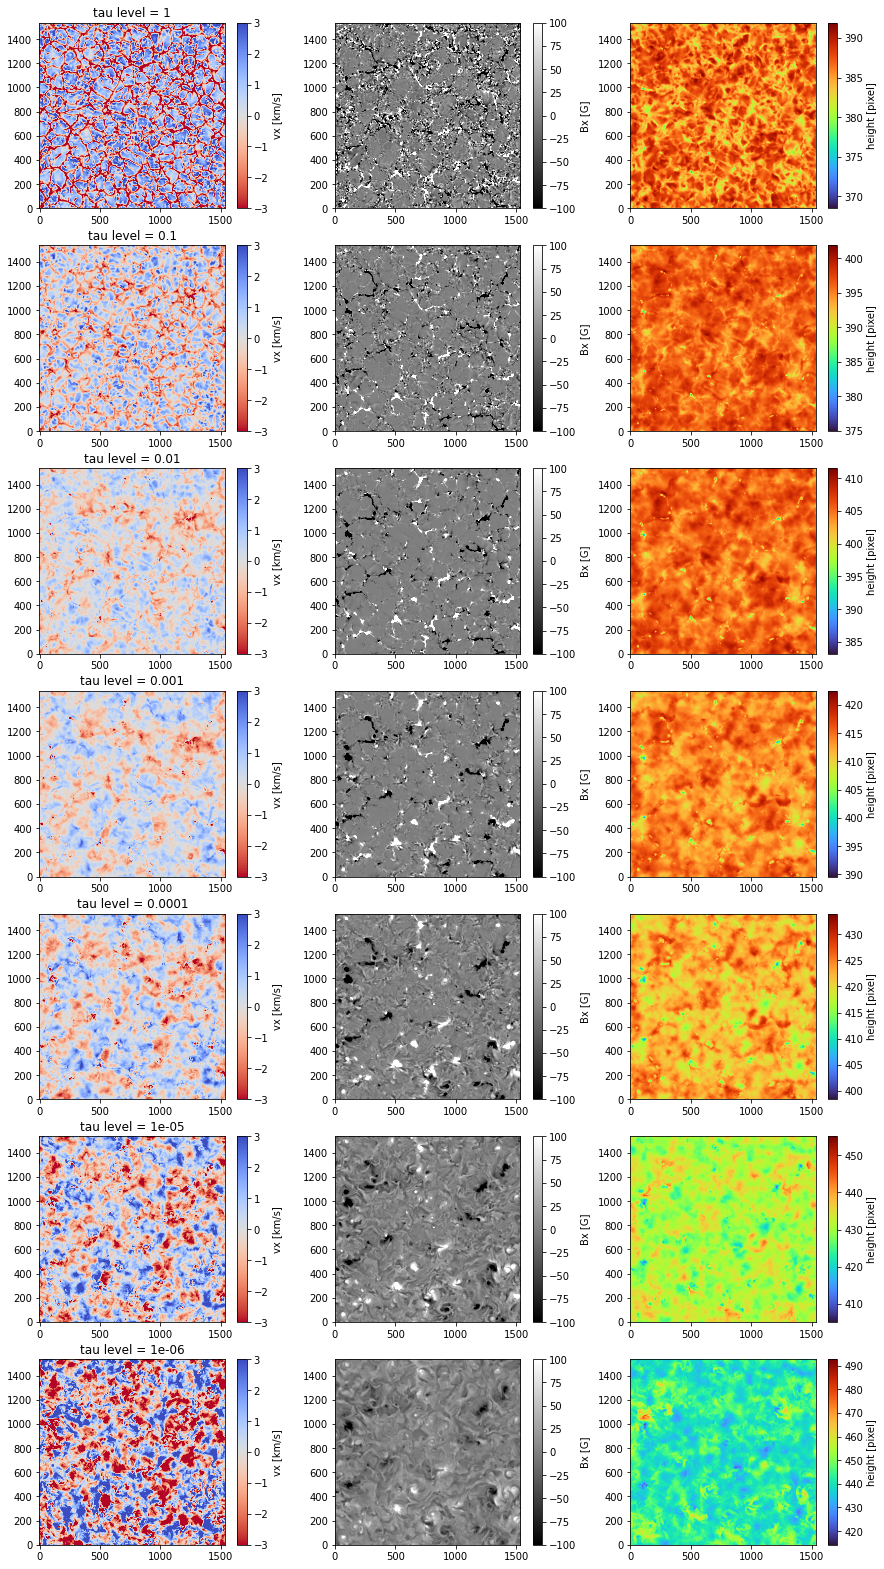

In [8]:
nlevels=len(tau_levels)

plt.figure(figsize=(15,4*nlevels))
for i in range(0,nlevels):
    plt.subplot(nlevels,3,1+3*i)
    plt.imshow((tau[i].vx/1e5).T,cmap='coolwarm_r',vmin=-3,vmax=3,origin='lower')
    plt.colorbar(label='vx [km/s]')
    plt.title(f"tau level = {tau_levels[i]}")
    plt.subplot(nlevels,3,2+3*i)
    plt.imshow((tau[i].Bx).T,cmap='gray',vmin=-100,vmax=100,origin='lower')
    plt.colorbar(label='Bx [G]')
    plt.subplot(nlevels,3,3+3*i)
    plt.imshow((tau[i][10,:,:]*512).T,cmap='turbo',origin='lower')
    plt.colorbar(label='height [pixel]')
plt.show()

In [9]:
yz_levels=[0, 192, 384, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500 ]
yz=[]
for level in yz_levels:
    yz.append(muram.MuramSlice(path+'2D/',iter,'yz',f"{level:04d}"))

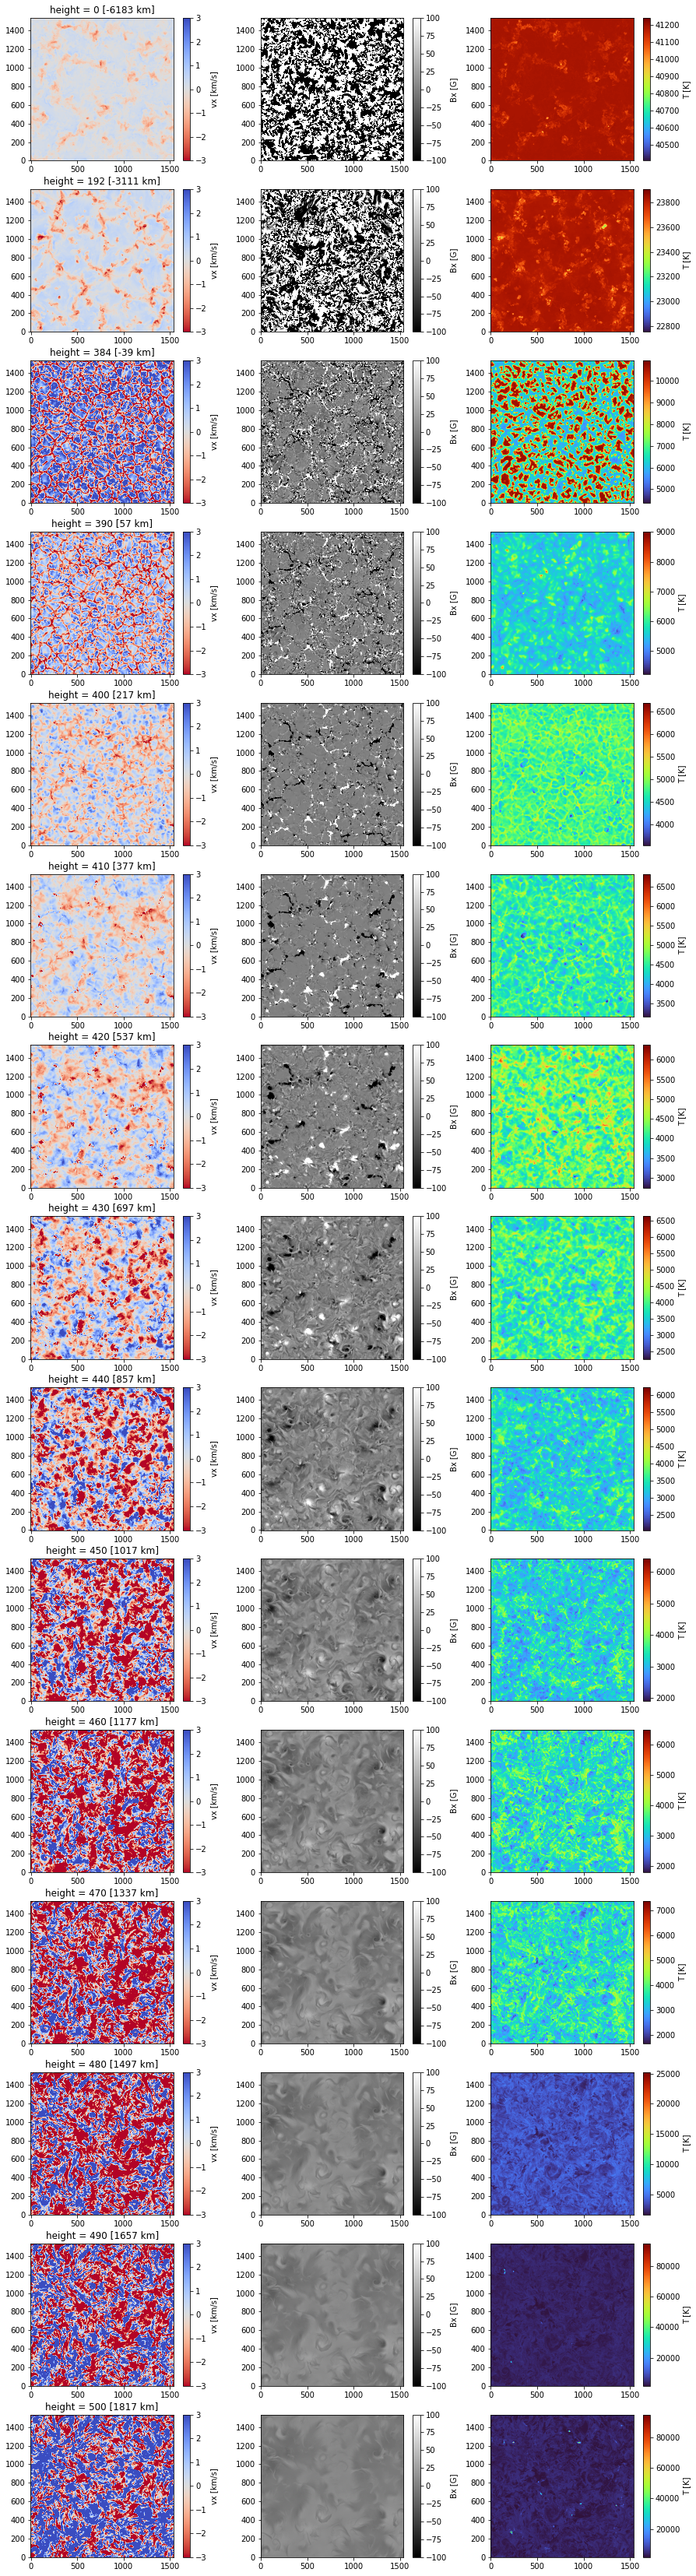

In [10]:
nlevels=len(yz_levels)

plt.figure(figsize=(15,4*nlevels))
for i in range(0,nlevels):
    plt.subplot(nlevels,3,1+3*i)
    plt.imshow((yz[i].vx/1e5).T,cmap='coolwarm_r',vmin=-3,vmax=3,origin='lower')
    plt.colorbar(label='vx [km/s]')
    plt.title(f"height = {yz_levels[i]} [{(yz_levels[i]-tau_ref)*16:.0f} km]")
    plt.subplot(nlevels,3,2+3*i)
    plt.imshow((yz[i].Bx).T,cmap='gray',vmin=-100,vmax=100,origin='lower')
    plt.colorbar(label='Bx [G]')
    plt.subplot(nlevels,3,3+3*i)
    plt.imshow((yz[i].Temp).T,cmap='turbo',origin='lower')
    plt.colorbar(label='T [K]')
plt.show()

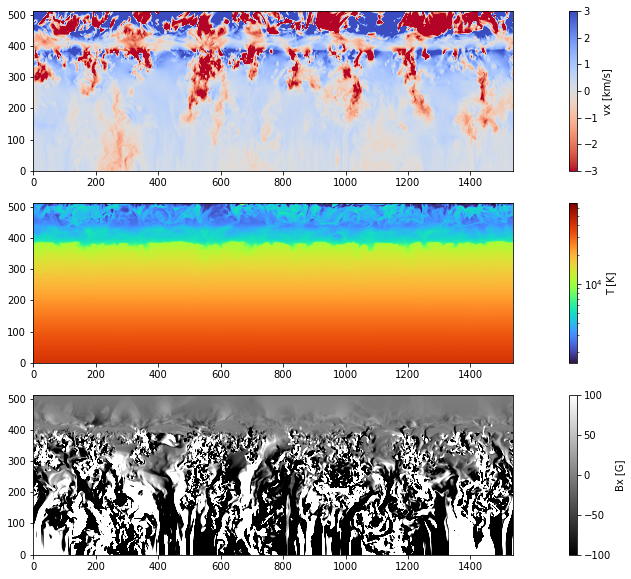

In [11]:
# Vertical slice for context:
xy=muram.MuramSlice(path+'2D/',iter,'xy','0768')

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.imshow(xy.vx.T/1e5,origin='lower',cmap='coolwarm_r',vmin=-3,vmax=3)
plt.colorbar(label='vx [km/s]')

plt.subplot(3,1,2)
plt.imshow(xy.Temp.T,origin='lower',cmap='turbo',norm=LogNorm())
plt.colorbar(label='T [K]')

plt.subplot(3,1,3)
plt.imshow(xy.Bx.T,origin='lower',cmap='gray',vmin=-100,vmax=100)
plt.colorbar(label='Bx [G]')

plt.show()

In [12]:
# This uses the memmap feature, i.e. this creates only a linkage to the data on disc. 
# The reading happens when you actually do something with the data
# B is not yet multiplied with sqrt(4*pi) since that would cause the memmap to read the whole B cube
# MuramSnap gives the full cube, MuramSubSnap a cutout of the top needed for RT modeling

run1=muram.MuramSubSnap(path+'3D/',iter)
run2=muram.MuramSnap(path+'3D/',iter)

In [13]:
# Variables present (eint-> internal energy, ne -> electron density, Q -> radiative heating/cooling, Qres, Qvis -> heating from numerical diffusivities) 
print(run1.available)
print(run2.available)

# Domain size
print(run1.Temp.shape)
print(run2.Temp.shape)

# Grid spacing, Domain extent, time
print(run1.Temp.dX)
print(run1.Temp.X)
print(run1.Temp.time)

print(run2.Temp.dX)
print(run2.Temp.X)
print(run2.Temp.time)

['rho', 'vx', 'vy', 'vz', 'eint', 'Bx', 'By', 'Bz', 'Temp', 'Pres', 'ne', 'tau']
['rho', 'vx', 'vy', 'vz', 'eint', 'Bx', 'By', 'Bz', 'Temp', 'Pres', 'ne', 'Q', 'tau', 'Qres', 'Qvis']
(121, 1536, 1536)
(512, 1536, 1536)
[1600000. 1600000. 1600000.]
[1.9360e+08 2.4576e+09 2.4576e+09]
3000.0
[1600000. 1600000. 1600000.]
[8.1920e+08 2.4576e+09 2.4576e+09]
3000.0


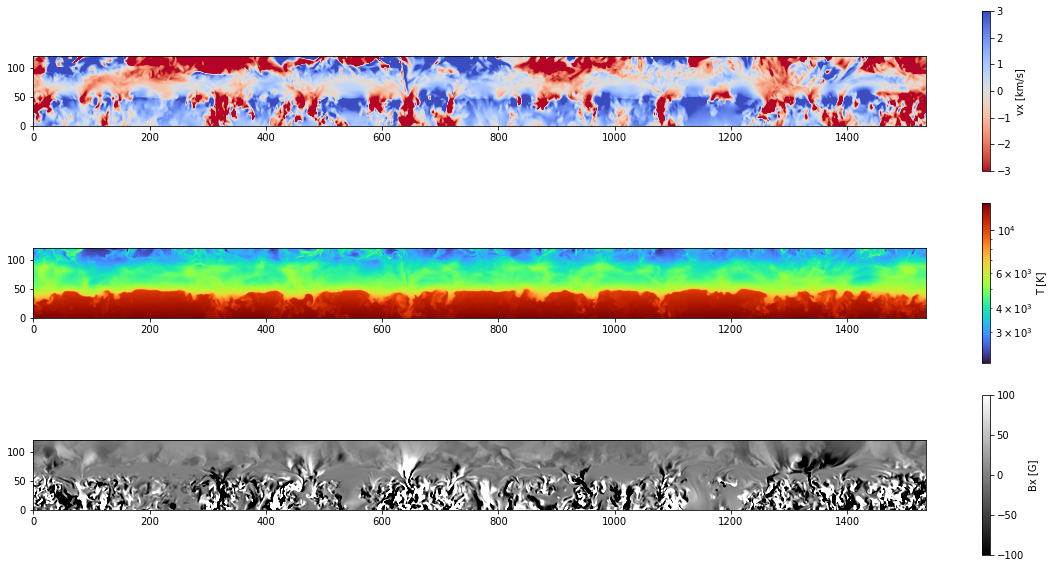

In [14]:
run=run1
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.imshow(run.vx[:,:,0]/1e5,origin='lower',cmap='coolwarm_r',vmin=-3,vmax=3)
plt.colorbar(label='vx [km/s]')

plt.subplot(3,1,2)
plt.imshow(run.Temp[:,:,0],origin='lower',cmap='turbo',norm=LogNorm())
plt.colorbar(label='T [K]')

plt.subplot(3,1,3)
plt.imshow(run.Bx[:,:,0]*B_unit,origin='lower',cmap='gray',vmin=-100,vmax=100)
plt.colorbar(label='Bx [G]')

plt.show()

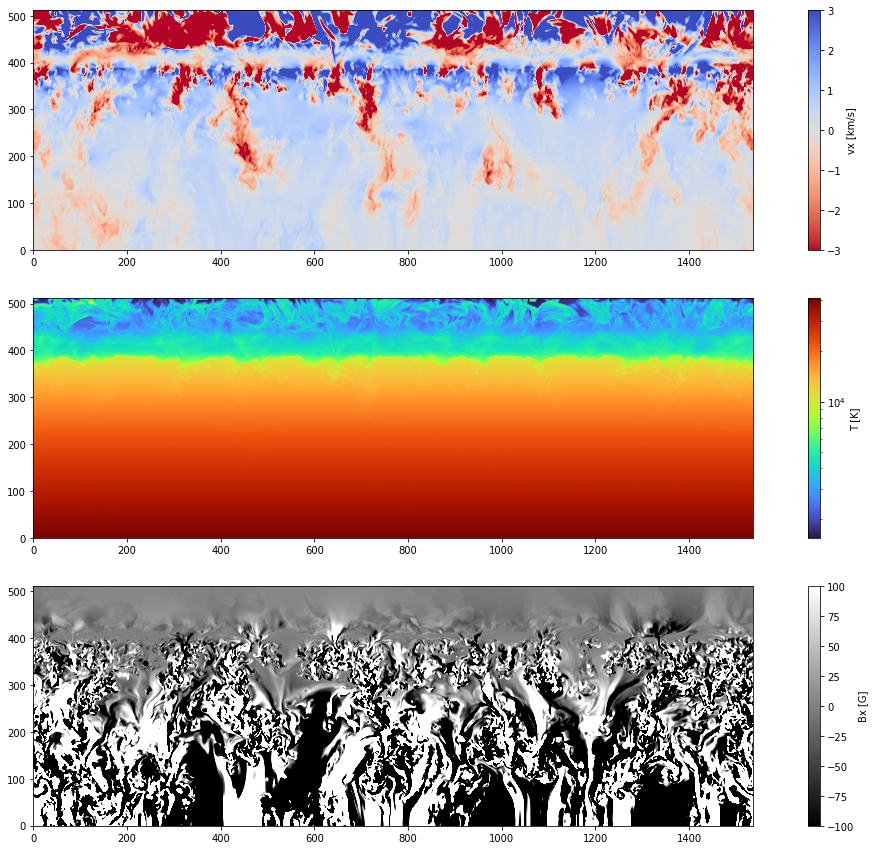

In [15]:
run=run2

plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.imshow(run.vx[:,:,0]/1e5,origin='lower',cmap='coolwarm_r',vmin=-3,vmax=3)
plt.colorbar(label='vx [km/s]')

plt.subplot(3,1,2)
plt.imshow(run.Temp[:,:,0],origin='lower',cmap='turbo',norm=LogNorm())
plt.colorbar(label='T [K]')

plt.subplot(3,1,3)
plt.imshow(run.Bx[:,:,0]*B_unit,origin='lower',cmap='gray',vmin=-100,vmax=100)
plt.colorbar(label='Bx [G]')

plt.show()